In [1]:
#Imports and dependencies
import os
from os.path import join
import torch
import torch.nn as nn
import math
import pandas as pd
import imageio
from skimage import img_as_ubyte
from scipy.ndimage.morphology import binary_dilation
from itertools import product
from typing import List
from tqdm import tqdm_notebook
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Textures
from pytorch3d.transforms import Rotate, Translate
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.renderer import (
    SfMPerspectiveCameras, OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights
)
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency
)
from dataclasses import dataclass, field, asdict, astuple
import numpy as np
#Plotting Libs
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import time
from copy import deepcopy

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from utils.visualization import plot_pointcloud
from utils.shapes import Sphere, SphericalSpiral
from utils.manager import RenderManager, ImageManager

['/home/alexis/Desktop/E3D', '/home/alexis/Desktop/E3D', '/home/alexis/anaconda3/envs/pytorch3d/lib/python37.zip', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/lib-dynload', '', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages', '/home/alexis/Desktop/pytorch3d', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/IPython/extensions', '/home/alexis/.ipython']


In [2]:
#Matplotlib config nums
mpl.rcParams['savefig.dpi'] = 90
mpl.rcParams['figure.dpi'] = 90
#Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == "cuda:0": torch.cuda.set_device()

### Load Object

In [3]:
#Load the object without textures and materials
verts, faces_idx, _ = load_obj("data/meshes/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/home/alexis/Desktop/pytorch3d/pytorch3d/io/obj_io.py:70: UserWarning:

Faces have invalid indices



### Create a Renderer

In [4]:
cameras = SfMPerspectiveCameras(device=device)


# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, lights=lights, cameras=cameras)
)

### Event Renderer

In [5]:
ON = 254
OFF = 0
threshold = 253/255

def gray(img):
    return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

def event_renderer(img1, img2, render_type):
    
    if render_type == "phong":
        img1 = gray(img1)
        img2 = gray(img2)
        
    diff_frames = img2 - img1
    
    threshold_diff = (diff_frames < threshold) * diff_frames

    tanh_diff = np.tanh(threshold_diff)
    #tanh_diff = np.where(tanh_diff != 0, OFF, ON)
    
    return tanh_diff

### Create a trajectory and Render

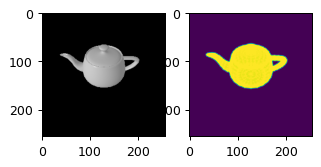

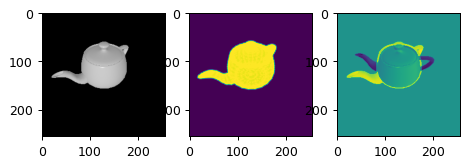

In [6]:
#Notes: benefit of having varying radiis for trajectory
#TODO: Move all the camera stuff to a dataclass

#Just to put these somewhere - this should be stored in param file after

def cam_trajectory_rotation(num_points: int = 2):
    """
    Returns: list of camera poses (R,T) from trajectory along a spherical spiral
    """
    
    shape = SphericalSpiral(
        c = 6,
        a = 3,
        t_min = .5*math.pi,
        t_max=.35*math.pi,
        num_points=num_points)
    up = torch.tensor([[0., 1., 1.]])
    R = []
    T = []
    for cp in shape._tuples:
        cp = torch.tensor(cp).to(device)
        R_new = look_at_rotation(cp[None, :], device=device)
        T_new = -torch.bmm(R_new.transpose(1,2), cp[None, :, None])[:, :, 0]
        if not len(R) and not len(T):
            R = [R_new]
            T = [T_new]
        else:
            R.append(R_new)
            T.append(T_new)
    return (R, T)

def cam_trajectory_transform(
    dist: float = 2.7,
    elev_range: list= [10, 50],
    azim_range: list= [-180, 180]):
    """
    Input
    Returns cameras from ranges of elevations and azimuths
    
    Not going to use this for now
    """
    
    elev = torch.linspace(elev_range[0], elev_range[1], batch_size)
    azim = torch.linspace(elev_range[0], elev_range[1], batch_size)
    R = []
    T = []
    for e, a in elev, azim:
        R_new, T_new = look_at_view_transform(dist=dist, elev=e, azim=a)
        R = torch.stack((R, R_new)) if R else R_new
        T = torch.stack((T, T_new)) if T else T_new
    return (R, T)
    
def render_trajectory(cam_poses, write_gif=True):
    
    renders = {
        "phong": None,
        "silhouette": None,
        "events": None
    }
    render_manager = RenderManager(
        types=list(renders.keys()),
        mesh_name = "teapot"
    )
    # Render the teapot providing the values of R and T.
    R, T = cam_poses
    for num in range(len(R)):
        if "phong" in renders.keys():
            image_ref = phong_renderer(meshes_world=teapot_mesh, R=R[num], T=T[num])
            image_ref = image_ref.cpu().numpy()
            plt.subplot(131)
            plt.imshow(image_ref.squeeze())
        if "silhouette" in renders.keys():
            silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R[num], T=T[num])
            silhouette = silhouette.cpu().numpy()
            plt.subplot(132)
            plt.imshow(silhouette.squeeze()[...,3])  # only plot the alpha channel of the RGBA image 
        render_manager.add_images(
            num,
            {"silhouette": silhouette.squeeze()[...,3], "phong": image_ref.squeeze()},
           R[num], T[num])
        if "events" in renders.keys():
            if num == 0:
                #prev_img_sil = silhouette
                prev_img_ref = image_ref
                plt.show()
                continue
            #sil_event_frame = event_renderer(prev_img_sil.squeeze(), silhouette.squeeze(), "silhouette")
            ref_event_frame = event_renderer(prev_img_ref.squeeze(), image_ref.squeeze(), "phong")            
            plt.subplot(133)
            plt.imshow(ref_event_frame)
            render_manager.add_event_frame(num, ref_event_frame)
            #prev_img_sil = silhouette
            prev_img_ref = image_ref
        plt.show()
        
    render_manager.close()
    return render_manager

    
cam_poses = cam_trajectory_rotation()
render = render_trajectory(cam_poses)

### Diff Model

In [7]:
def neg_iou_loss(predict, target):
    dims = tuple(range(predict.ndimension())[1:])
    intersect = (predict * target).sum(dims)
    union = (predict + target - predict * target).sum(dims) + 1e-6
    return 1. - (intersect / union).sum() / intersect.nelement()

In [8]:
class ImageBasedDifferentiableModel(nn.Module):
    
    def __init__(self, device, template_mesh = None):
        super().__init__()
        
        self.device = device
        
        #Create a source mesh
        if not template_mesh:
            template_mesh = ico_sphere(2, device)
        
        verts, faces = template_mesh.get_mesh_verts_faces(0)
        #Initialize each vert to have no tetxture
        verts_rgb = torch.ones_like(verts)[None]
        textures = Textures(verts_rgb=verts_rgb.to(self.device))
        self.template_mesh = Meshes(
            verts=[verts.to(self.device)],
            faces=[faces.to(self.device)],
            textures = textures
        )
        
        self.register_buffer('vertices', self.template_mesh.verts_padded())
        self.register_buffer('faces', self.template_mesh.faces_padded())
        self.register_buffer('textures', textures.verts_rgb_padded())
        
        deform_verts = torch.zeros_like(self.template_mesh.verts_packed(), device=device, requires_grad=True)
        #deform_verts = torch.full(self.template_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
        #Create an optimizable parameter for the mesh
        self.register_parameter('deform_verts', nn.Parameter(deform_verts).to(self.device))
        
        laplacian_loss = mesh_laplacian_smoothing(template_mesh, method="uniform")
        flatten_loss = mesh_normal_consistency(template_mesh)
        
    def forward(self, batch_size):
        #Offset the mesh
        deformed_mesh_verts = self.template_mesh.offset_verts(self.deform_verts)
        texture = Textures(verts_rgb = self.textures)
        deformed_mesh = Meshes(verts=deformed_mesh_verts.verts_padded(), faces=deformed_mesh_verts.faces_padded(), textures=texture)
        deformed_meshes = deformed_mesh.extend(batch_size)
    
        laplacian_loss = mesh_laplacian_smoothing(deformed_mesh, method="uniform")
        flatten_loss = mesh_normal_consistency(deformed_mesh)
        
        return deformed_meshes, laplacian_loss, flatten_loss
    

# IMAGE-BASED
### Initialize the model

In [ ]:
weight_silhouette = 10
weight_laplacian = .01
weight_flatten = .0001

# We will save images periodically and compose them into a GIF.
filename_output = "./projection_loss.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

#Create a loss plotting object
#loss_ax = plot_loss(num_losses = 3)

# Initialize a model using the renderer, template mesh and reference image
model = ImageBasedDifferentiableModel(device).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=.15) #Hyperparameter tuning

R, T = render._trajectory
images_gt = torch.round(render._images().to(device) / 255)
cameras = SfMPerspectiveCameras(device=device, R=R, T=T*1.2)


### Run Optimization

In [ ]:
loop = tqdm_notebook(range(2000))
laplacian_losses = []
flatten_losses = []
silhouette_losses = []

for i in loop:
    
    mesh, laplacian_loss, flatten_loss = model(len(images_gt))

    images_pred = silhouette_renderer(mesh.clone(), device=device, cameras=cameras)
    events_pred = []
    prev_img = images_pred[0]
    for img in images_pred[1:-1]:
        ev = event_renderer(np.array())
        events_pred.append(event_renderer(prev_img.detach().squeeze(), img.detach().squeeze()))
    
    silhouette_loss = neg_iou_loss(images_gt, images_pred[..., -1])
    #ssd_loss = torch.sum((images_gt - images_pred[...,-1]) ** 2).mean()
    
    loss = silhouette_loss * weight_silhouette + laplacian_loss * weight_laplacian + flatten_loss * weight_flatten
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    silhouette_losses.append(silhouette_loss * weight_silhouette)
    laplacian_losses.append(laplacian_loss * weight_laplacian)
    flatten_losses.append(flatten_loss * weight_flatten)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        #Write images
        image = images_pred.detach().cpu().numpy()[0]
        writer.append_data((255*image).astype(np.uint8))
        imageio.imsave(f"data/dump/mesh_{i}.png", (255*image).astype(np.uint8))
        
        f, (ax1, ax2) = plt.subplots(1, 2)
        
        image = img_as_ubyte(image)
        ax1.imshow(image)
        ax1.set_title("Deformed Mesh")
        
        ax2.plot(silhouette_losses, label="Silhouette Loss")
        ax2.plot(laplacian_losses, label="Laplacian Loss")
        ax2.plot(flatten_losses, label="Flatten Loss")
        ax2.legend(fontsize="16")
        ax2.set_xlabel("Iteration", fontsize="16")
        ax2.set_ylabel("Loss", fontsize="16")
        ax2.set_title("Loss vs iterations", fontsize="16")
        
        plt.show()
    

# EVENT-BASED

### Initialize the model

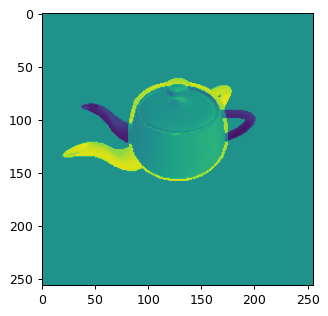

In [10]:
weight_silhouette = 10
weight_laplacian = .01
weight_flatten = .0001

# We will save images periodically and compose them into a GIF.
filename_output = "./projection_loss.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

#Create a loss plotting object
#loss_ax = plot_loss(num_losses = 3)

# Initialize a model using the renderer, template mesh and reference image
model = ImageBasedDifferentiableModel(device).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=.15) #Hyperparameter tuning

R, T = render._trajectory
images_gt = render._images(type_key = "silhouette").to(device)
events = render._events().to(device)
cameras = SfMPerspectiveCameras(device=device, R=R, T=T)

plt.imshow(np.array(events[0]))